In [30]:
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt

# --- LOAD TEST DATA (01–07) ---

data_dir = Path(r"C:\Users\henkw\Group 13\2nd Test")

dfs = []

for i in range(1, 8):
    file_path = data_dir / f"{i:02d}.txt"

    df = pd.read_csv(
        file_path,
        sep="\t",
        decimal=",",
        skipinitialspace=True,
        usecols=[0, 1]   # strictly keep only the first two columns
    )

    df.columns = ["displacement", "force"]
    df["file_id"] = i

    dfs.append(df)

# Combined test DataFrame
data = pd.concat(dfs, ignore_index=True)

print(data.head())
print(data.shape)


# --- LOAD PRBM MOMENT DATA ---

PRBM_moments_path = Path("theta_M_new_M_old_filtered.csv")

PRBM_moments = pd.read_csv(PRBM_moments_path)

print(PRBM_moments.head())
print(PRBM_moments.shape)



   displacement    force  file_id
0       87.0001 -1.28499        1
1       87.0001 -1.30924        1
2       87.0001 -1.28499        1
3       87.0001 -1.28499        1
4       87.0001 -1.30924        1
(5442, 3)
      theta     M_new     M_old
0  0.000000 -0.001756  0.000001
1 -0.035102 -0.003389 -0.002101
2 -0.070203 -0.005023 -0.004169
3 -0.105305 -0.006644 -0.006169
4 -0.140406 -0.008237 -0.008067
(180, 3)


In [76]:
import numpy as np
import pandas as pd

fem_path = r"C:\Users\henkw\Downloads\ANSYSTorDef.csv"

# Semicolon separated, comma decimals
FEM = pd.read_csv(fem_path, sep=";", decimal=",")

# Clean header whitespace only
FEM.columns = FEM.columns.str.strip()

# Ensure numeric dtype
FEM["Rotation (rad)"] = pd.to_numeric(FEM["Rotation (rad)"], errors="coerce")
FEM["Torque (Nmm)"] = pd.to_numeric(FEM["Torque (Nmm)"], errors="coerce")

# Drop invalid rows
FEM = FEM.dropna(subset=["Rotation (rad)", "Torque (Nmm)"]).copy()

# Shift angles by minus 90 degrees
FEM["Rotation (rad)"] = FEM["Rotation (rad)"] + (np.pi / 2)

# Flip direction: anti clockwise to clockwise
FEM["Rotation (rad)"] = -FEM["Rotation (rad)"]

# Wrap into one full clockwise rotation: 0 to -2*pi
two_pi = 2 * np.pi
FEM["Rotation_wrapped"] = -np.mod(
    -FEM["Rotation (rad)"].to_numpy(),
    two_pi
)

# Convert torque from Nmm to Nm
FEM["Torque (Nm)"] = FEM["Torque (Nmm)"] / 1000.0

# Scale FEM moment
moment_scaler_fem = 0.05  # adjust freely
FEM["Torque_scaled"] = FEM["Torque (Nm)"] * moment_scaler_fem

# Sort for plotting
FEM = FEM.sort_values("Rotation_wrapped").reset_index(drop=True)

print(FEM.head())



   Rotation (rad)  Torque (Nmm)  Rotation_wrapped  Torque (Nm)  Torque_scaled
0       -6.269546      -3.13023         -6.269546    -0.003130      -0.000157
1       -6.163566       1.64256         -6.163566     0.001643       0.000082
2       -6.057596       5.91811         -6.057596     0.005918       0.000296
3       -5.986946       8.41341         -5.986946     0.008413       0.000421
4       -5.916296      10.54840         -5.916296     0.010548       0.000527


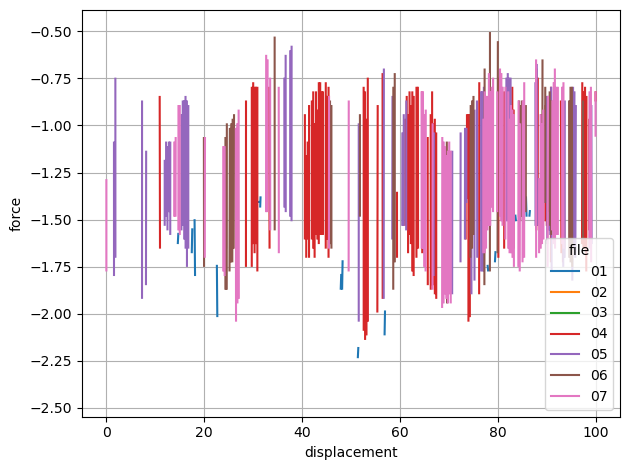

In [77]:


# Align all measurements on the same displacement positions (union of all x values)
# If a file has repeated displacement values, average them first
wide = (
    data.groupby(["file_id", "displacement"], as_index=False)["force"].mean()
        .pivot(index="displacement", columns="file_id", values="force")
        .sort_index()
)

# Plot all 7 measurements in one graph, aligned by displacement
plt.figure()
for file_id in wide.columns:
    plt.plot(wide.index, wide[file_id], label=f"{file_id:02d}")

plt.xlabel("displacement")
plt.ylabel("force")
plt.legend(title="file")
plt.grid(True)
plt.tight_layout()
plt.show()

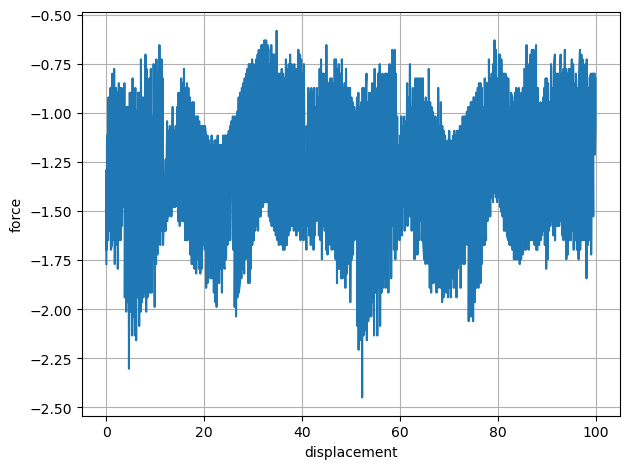

In [78]:
import matplotlib.pyplot as plt

# Extract measurement 7 from the existing DataFrame
df7 = data[data["file_id"] == 7].copy()

# If there are duplicate displacement values, average them
df7 = (
    df7.groupby("displacement", as_index=False)["force"]
       .mean()
       .sort_values("displacement")
)

# Plot
plt.figure()
plt.plot(df7["displacement"], df7["force"])
plt.xlabel("displacement")
plt.ylabel("force")
plt.grid(True)
plt.tight_layout()
plt.show()


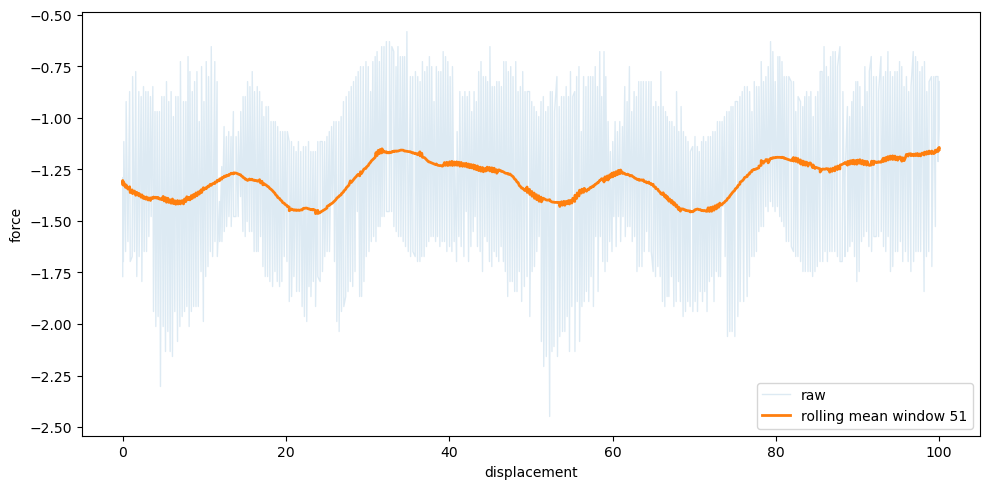

In [79]:
import numpy as np
import matplotlib.pyplot as plt

df7 = data.loc[data["file_id"] == 7, ["displacement", "force"]].copy()
df7 = df7.groupby("displacement", as_index=False)["force"].mean()
df7 = df7.sort_values("displacement")

x = df7["displacement"].to_numpy()
y = df7["force"].to_numpy()

window = 51  # try 21, 51, 101 depending on how noisy it is
if window % 2 == 0:
    window += 1

y_smooth = (
    df7["force"]
    .rolling(window=window, center=True, min_periods=1)
    .mean()
    .to_numpy()
)

plt.figure(figsize=(10, 5))
plt.plot(x, y, alpha=0.15, linewidth=1, label="raw")
plt.plot(x, y_smooth, linewidth=2, label=f"rolling mean window {window}")

plt.xlabel("displacement")
plt.ylabel("force")
plt.legend()
plt.tight_layout()
plt.show()


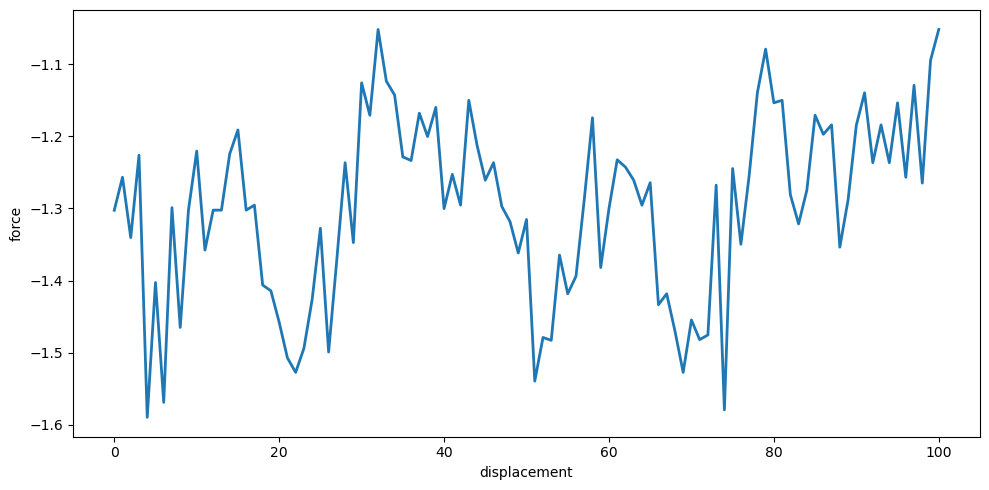

In [80]:
import numpy as np
import matplotlib.pyplot as plt

df7 = data.loc[data["file_id"] == 7, ["displacement", "force"]].copy()
df7 = df7.dropna()
df7 = df7.sort_values("displacement")

x = df7["displacement"].to_numpy()
y = df7["force"].to_numpy()

dx = 1  # bin width in displacement units, try 0.1, 0.2, 0.5
x_min, x_max = np.nanmin(x), np.nanmax(x)
grid = np.arange(x_min, x_max + dx, dx)

idx = np.digitize(x, grid) - 1
y_bin = np.full(len(grid), np.nan)

for k in range(len(grid)):
    m = idx == k
    if np.any(m):
        y_bin[k] = np.mean(y[m])

plt.figure(figsize=(10, 5))
plt.plot(grid, y_bin, linewidth=2)

plt.xlabel("displacement")
plt.ylabel("force")
plt.tight_layout()
plt.show()


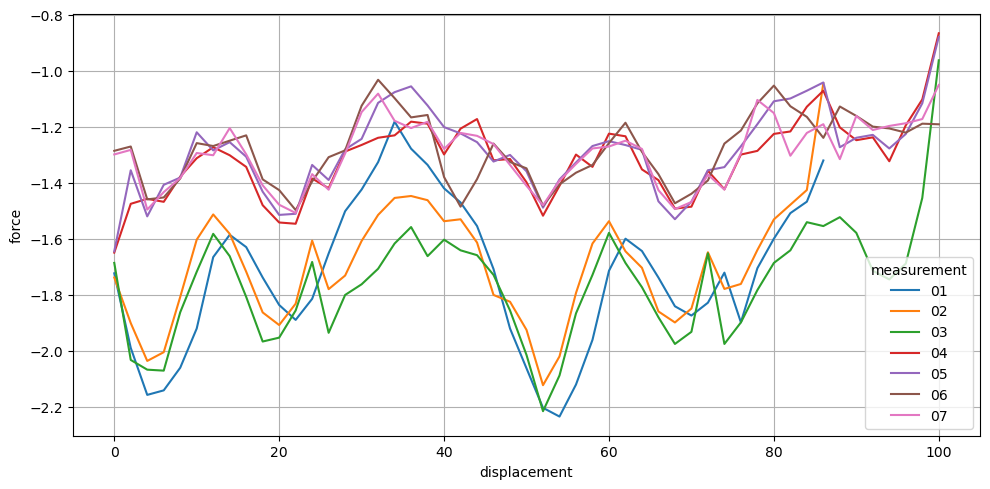

In [81]:
import numpy as np
import matplotlib.pyplot as plt

dx = 2.0  # bin width

plt.figure(figsize=(10, 5))

for file_id in sorted(data["file_id"].unique()):
    df = data.loc[data["file_id"] == file_id, ["displacement", "force"]].copy()
    df = df.dropna().sort_values("displacement")

    x = df["displacement"].to_numpy()
    y = df["force"].to_numpy()

    x_min, x_max = np.nanmin(x), np.nanmax(x)
    grid = np.arange(x_min, x_max + dx, dx)

    idx = np.digitize(x, grid) - 1
    y_bin = np.full(len(grid), np.nan)

    for k in range(len(grid)):
        m = idx == k
        if np.any(m):
            y_bin[k] = np.mean(y[m])

    plt.plot(grid, y_bin, label=f"{file_id:02d}")

plt.xlabel("displacement")
plt.ylabel("force")
plt.legend(title="measurement")
plt.grid(True)
plt.tight_layout()
plt.show()


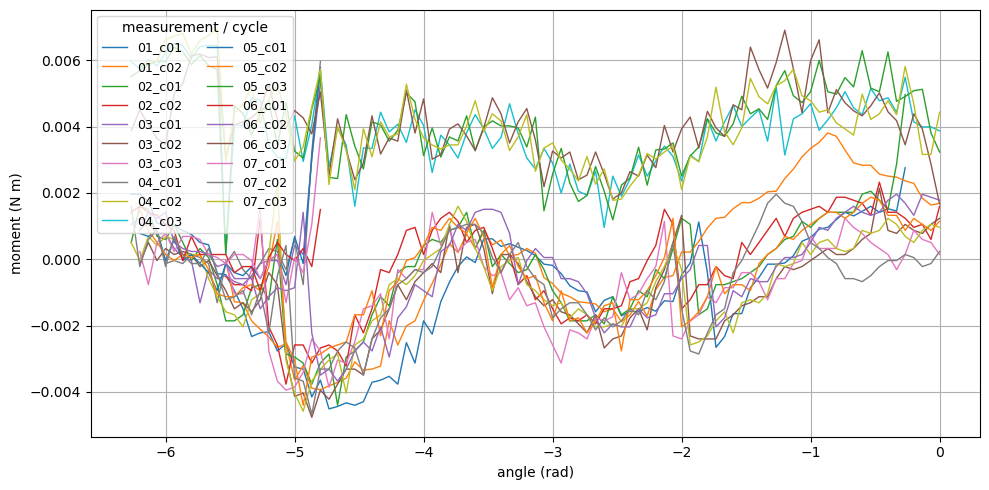

In [91]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

r = 7.5  # mm
r_m = r / 1000.0  # m

x_ref = 100.0
theta_ref = -(5/6) * np.pi + 180  # rad at displacement 100

dx = 0.5
dtheta = dx / r
two_pi = 2 * np.pi

F_weight = 0.17 * 9.81  # N

data = data.copy()

# Add weight force to measured force
data["force_total"] = data["force"] + F_weight

# Map displacement to angle
data["theta"] = theta_ref + (data["displacement"] - x_ref) / r

# Wrap into 0 to -2*pi
data["theta_wrapped"] = -np.mod(-data["theta"].to_numpy(), two_pi)

# Convert force to moment about pulley axis: M = F * r
data["moment_total"] = data["force_total"] * r_m

# Split each original measurement into cycles based on wrap jumps
segments = []
for file_id in sorted(data["file_id"].unique()):
    df = data.loc[data["file_id"] == file_id, ["moment_total", "theta_wrapped"]].copy()

    # Keep original time/order for detecting wrap boundaries
    df = df.sort_index()

    tw = df["theta_wrapped"].to_numpy()
    jump = np.diff(tw)
    boundary = np.concatenate(([False], jump > np.pi))
    df["cycle"] = np.cumsum(boundary).astype(int)

    df["set_id"] = f"{file_id:02d}_" + "c" + (df["cycle"] + 1).astype(str).str.zfill(2)
    segments.append(df)

data_split = pd.concat(segments, ignore_index=True)

# Fixed grid for one clockwise rotation: 0 down to -2*pi
theta_grid = np.arange(0.0, -two_pi - dtheta, -dtheta)

plt.figure(figsize=(10, 5))

for set_id in sorted(data_split["set_id"].unique()):
    df = data_split.loc[
        data_split["set_id"] == set_id, ["theta_wrapped", "moment_total"]
    ].dropna()

    th = df["theta_wrapped"].to_numpy()
    y = df["moment_total"].to_numpy()

    idx = np.digitize(th, theta_grid) - 1
    y_bin = np.full(len(theta_grid), np.nan)

    for k in range(len(theta_grid)):
        m = idx == k
        if np.any(m):
            y_bin[k] = np.mean(y[m])

    plt.plot(theta_grid, y_bin, linewidth=1, label=set_id)

plt.xlabel("angle (rad)")
plt.ylabel("moment (N m)")
plt.legend(title="measurement / cycle", ncol=2, fontsize=9)
plt.grid(True)
plt.tight_layout()
plt.savefig("raw_measurements.png", dpi=300, bbox_inches="tight")
plt.show()


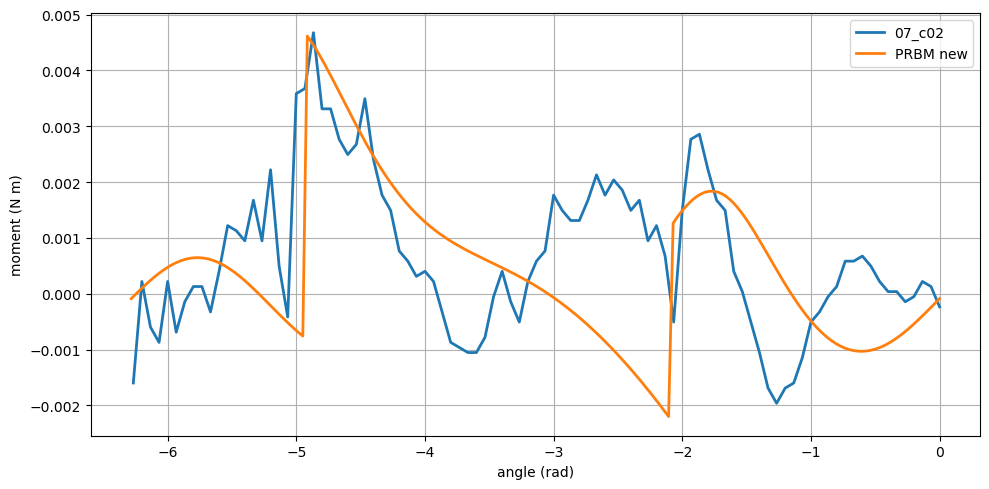

In [83]:
import numpy as np
import matplotlib.pyplot as plt

dx = 0.5
dtheta = dx / r
two_pi = 2 * np.pi

moment_scaler = 0.05  # <<< adjust this value

df_sel = data_split[data_split["set_id"].isin(["07_c02"])].copy()

theta_grid = np.arange(0.0, -two_pi - dtheta, -dtheta)

plt.figure(figsize=(10, 5))

# measurement 05_c02
set_id = "07_c02"
df = df_sel.loc[
    df_sel["set_id"] == set_id, ["theta_wrapped", "moment_total"]
].dropna()

th = df["theta_wrapped"].to_numpy()
y = df["moment_total"].to_numpy()

idx = np.digitize(th, theta_grid) - 1
y_bin = np.full(len(theta_grid), np.nan)

for k in range(len(theta_grid)):
    m = idx == k
    if np.any(m):
        y_bin[k] = np.mean(y[m])

plt.plot(theta_grid, -y_bin, linewidth=2, label=set_id)

# PRBM curves
prbm = PRBM_moments.dropna(subset=["theta"]).copy()

theta_prbm = prbm["theta"].to_numpy()
M_new = prbm["M_new"].to_numpy() * moment_scaler
M_old = prbm["M_old"].to_numpy() * moment_scaler

# sort by theta for clean plotting
order = np.argsort(theta_prbm)
theta_prbm = theta_prbm[order]
M_new = M_new[order]
M_old = M_old[order]

plt.plot(theta_prbm, M_new, linewidth=2, label="PRBM new")


plt.xlabel("angle (rad)")
plt.ylabel("moment (N m)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()




C:\Users\henkw\AppData\Local\Temp\ipykernel_27068\1804574114.py:60: RuntimeWarning: Mean of empty slice
  avg_curve = np.nanmean(np.vstack(binned_curves), axis=0)


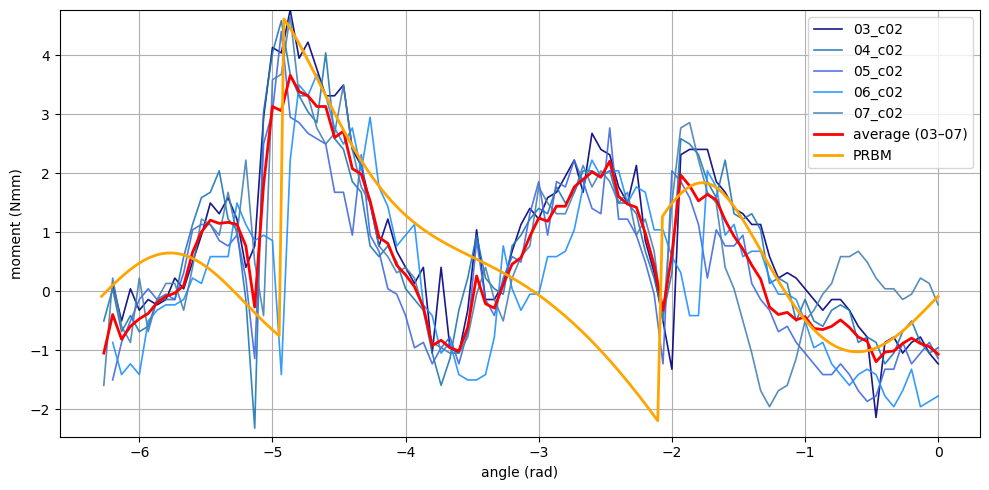

Figure saved to moment_comparison_Nmm.png


In [90]:
import numpy as np
import matplotlib.pyplot as plt

dx = 0.5
dtheta = dx / r
two_pi = 2 * np.pi

moment_scaler_prbm = 0.05
moment_scaler_fem = 0.1

theta_grid = np.arange(0.0, -two_pi - dtheta, -dtheta)

set_ids = ["03_c02", "04_c02", "05_c02", "06_c02", "07_c02"]

plt.figure(figsize=(10, 5))

binned_curves = []

blue_shades = [
    "navy",
    "tab:blue",
    "royalblue",
    "dodgerblue",
    "steelblue",
]

all_y = []

# --- MEASUREMENTS (already in Nm -> convert to Nmm) ---
for set_id, c in zip(set_ids, blue_shades):
    df = data_split.loc[
        data_split["set_id"] == set_id, ["theta_wrapped", "moment_total"]
    ].dropna()

    th = df["theta_wrapped"].to_numpy()
    y = df["moment_total"].to_numpy() * 1000.0  # Nm -> Nmm

    idx = np.digitize(th, theta_grid) - 1
    y_bin = np.full(len(theta_grid), np.nan)

    for k in range(len(theta_grid)):
        m = idx == k
        if np.any(m):
            y_bin[k] = np.mean(y[m])

    y_plot = -y_bin
    binned_curves.append(y_plot)
    all_y.append(y_plot)

    plt.plot(
        theta_grid,
        y_plot,
        linewidth=1.2,
        alpha=0.9,
        color=c,
        label=set_id,
    )

# --- AVERAGE ---
avg_curve = np.nanmean(np.vstack(binned_curves), axis=0)
all_y.append(avg_curve)

plt.plot(
    theta_grid,
    avg_curve,
    linewidth=2,
    color="red",
    label="average (03–07)",
)

# --- PRBM (scaled, converted to Nmm) ---
prbm = PRBM_moments.dropna(subset=["theta"]).copy()

theta_prbm = prbm["theta"].to_numpy()
M_prbm = prbm["M_new"].to_numpy() * moment_scaler_prbm * 1000.0  # Nm -> Nmm

order = np.argsort(theta_prbm)
theta_prbm = theta_prbm[order]
M_prbm = M_prbm[order]

all_y.append(M_prbm)

plt.plot(
    theta_prbm,
    M_prbm,
    linewidth=2,
    color="orange",
    label="PRBM",
)

# --- FEM (scaled, converted to Nmm) ---
theta_fem = FEM["Rotation_wrapped"].to_numpy()
M_fem = FEM["Torque (Nm)"].to_numpy() * moment_scaler_fem * 1000.0  # Nm -> Nmm

order_fem = np.argsort(theta_fem)
theta_fem = theta_fem[order_fem]
M_fem = M_fem[order_fem]

all_y.append(M_fem)

# plt.plot(
#     theta_fem,
#     M_fem,
#     linewidth=2,
#     color="green",
#     label="FEM",
# )

# --- CONSISTENT Y LIMITS ---
y_all = np.concatenate([arr[np.isfinite(arr)] for arr in all_y])
plt.ylim(y_all.min(), y_all.max())

plt.xlabel("angle (rad)")
plt.ylabel("moment (Nmm)")
plt.legend()
plt.grid(True)
plt.tight_layout()

# --- SAVE FIGURE ---
save_path = "moment_comparison_Nmm.png"
plt.savefig(save_path, dpi=300, bbox_inches="tight")
plt.show()

print(f"Figure saved to {save_path}")





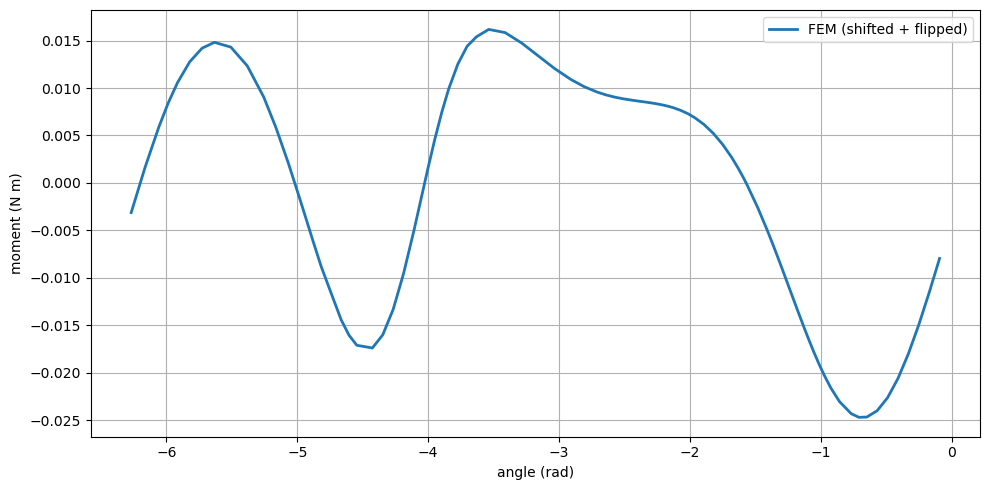

In [85]:
import numpy as np
import matplotlib.pyplot as plt

theta_fem = FEM["Rotation_wrapped"].to_numpy()
M_fem = FEM["Torque (Nm)"].to_numpy()

order = np.argsort(theta_fem)
theta_fem = theta_fem[order]
M_fem = M_fem[order]

plt.figure(figsize=(10, 5))
plt.plot(theta_fem, M_fem, linewidth=2, label="FEM (shifted + flipped)")

plt.xlabel("angle (rad)")
plt.ylabel("moment (N m)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


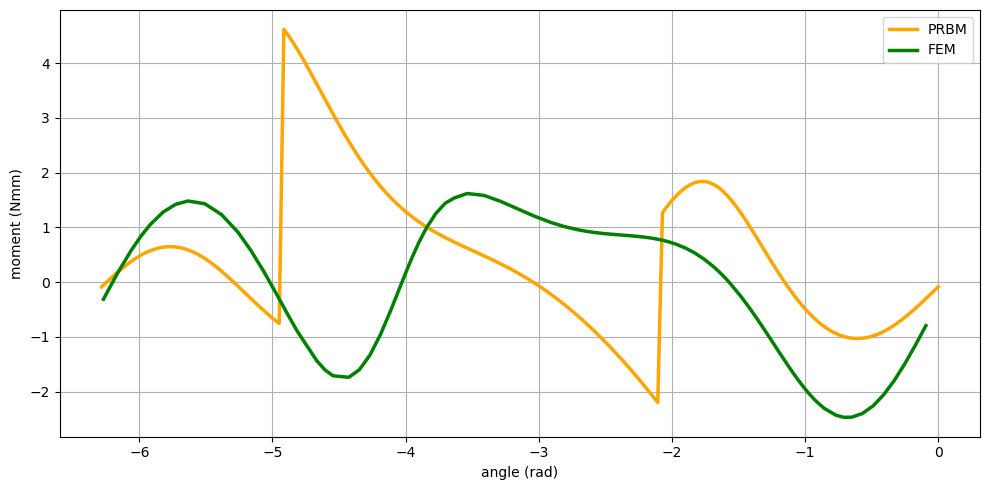

Figure saved to FEM_vs_PRBM_Nmm.png


In [89]:
import numpy as np
import matplotlib.pyplot as plt

# --- SCALERS ---
moment_scaler_prbm = 0.05
moment_scaler_fem = 0.1

plt.figure(figsize=(10, 5))

# --- PRBM ---
prbm = PRBM_moments.dropna(subset=["theta"]).copy()

theta_prbm = prbm["theta"].to_numpy()
M_prbm = prbm["M_new"].to_numpy() * moment_scaler_prbm * 1000.0  # Nm -> Nmm

order = np.argsort(theta_prbm)
theta_prbm = theta_prbm[order]
M_prbm = M_prbm[order]

plt.plot(
    theta_prbm,
    M_prbm,
    linewidth=2.5,
    color="orange",
    label="PRBM",
)

# --- FEM ---
theta_fem = FEM["Rotation_wrapped"].to_numpy()
M_fem = FEM["Torque (Nm)"].to_numpy() * moment_scaler_fem * 1000.0  # Nm -> Nmm

order_fem = np.argsort(theta_fem)
theta_fem = theta_fem[order_fem]
M_fem = M_fem[order_fem]

plt.plot(
    theta_fem,
    M_fem,
    linewidth=2.5,
    color="green",
    label="FEM",
)

# --- AXES & STYLE ---
plt.xlabel("angle (rad)")
plt.ylabel("moment (Nmm)")
plt.legend()
plt.grid(True)
plt.tight_layout()

# --- SAVE ---
save_path = "FEM_vs_PRBM_Nmm.png"
plt.savefig(save_path, dpi=300, bbox_inches="tight")
plt.show()

print(f"Figure saved to {save_path}")
